# Performance Evaluation

The first part of this notebook summarizes the conventional performance measures for an investment fund. The second part does a "style analysis" to find out how the fund has changed its portfolio weights over time.

## Load Packages and Extra Functions

In [1]:
using Printf, Dates, DelimitedFiles, Statistics

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))           #pyplot or gr
gr(size=(480,320))
default(fmt = :png)

# Loading Data

## A Remark on the Code
In the code below, `x` from `readdlm()` is an `Any` matrix (the first column are strings, the other columns are numbers). It often helps to convert to the right type. For the numbers in column `2:end` we can do that by `Float64.(x[:,2:end])` (or alternatively by `convert.(Float64,x[:,2:end])`).

In [3]:
(x,header) = readdlm("Data/Fin1PerfEvalEmp.csv",',',header=true)

(IndNames,FundNames) = (header[2:9],header[10:11])     #names of variables

dN             = Date.(x[:,1],"yyyy-mm-dd")       #convert to Date
(Rb,RFunds,Rf) = (Float64.(x[:,2:9]),Float64.(x[:,10:11]),Float64.(x[:,12]));  #convert to Float64

# Performance Evaluation

The next few cells report a number of different performance measures for the funds.

## Sharpe Ratio and M²

In [4]:
Re  = RFunds .- Rf           #excess returns of the funds
Rme = Rb[:,1] - Rf           #excess returns of the market (S&P 500)

μᵉp = mean(Re,dims=1)        #average excess returns of funds, 1xn
σp  = std(Re,dims=1)         #std, 1xn

μᵉm = mean(Rme)              #average excess returns of market
σm  = std(Rme)

SRp = (μᵉp./σp)*sqrt(52)       #Sharpe ratio
SRm = (μᵉm/σm)*sqrt(52)

M²p = (SRp.-SRm)*σm*sqrt(52)*100
M²m = 0                      #(SRm.-SRm)*σm=0

xut = hcat([μᵉm;μᵉp']*52*100,[SRm;SRp'],[M²m;M²p'])
printmat(xut,colNames=["ERe","SR","M²"],rowNames=["Market";FundNames])

                                        ERe        SR        M²
Market                                4.696     0.268     0.000
Putnam Asset Allocation: Growth A     4.143     0.283     0.265
Vanguard Wellington                   5.234     0.489     3.865



## Appraisal Ratio

In [5]:
T = size(Re,1)
x = [ones(T) Rme]

b  = x\Re            #2xn, OLS Re = α + β*Rme + ϵ, n = number of funds
ϵ  = Re - x*b        #Txn, residuals
σϵ = std(ϵ,dims=1)   #1xn

ARp = (b[1:1,:]*52*100)./(σϵ*sqrt(52)*100)   #b[1:1,:] is 1xn
ARm = 0

xut = [ARm;ARp']
printmat(xut,colNames=["AR"],rowNames=["Market";FundNames])

                                         AR
Market                                0.000
Putnam Asset Allocation: Growth A     0.092
Vanguard Wellington                   0.671



## Treynor's Ratio and T²

In [6]:
TRp = 52*100*μᵉp./b[2:2,:]
TRm = 52*100*μᵉm/1           #market has β=1

T²p = TRp .- μᵉm*52*100
T²m = 0                      #TRm - μᵉm*52*100

xut = hcat([TRm;TRp'],[T²m;T²p'])
printmat(xut,colNames=["TR","T²"],rowNames=["Market";FundNames])

                                         TR        T²
Market                                4.696     0.000
Putnam Asset Allocation: Growth A     5.193     0.497
Vanguard Wellington                   9.158     4.462



# Style Analysis

using the packages [Convex.jl](https://github.com/jump-dev/Convex.jl) for the interface and [SCS.jl](https://github.com/jump-dev/SCS.jl) for the optimization algorithm.

Notice:  
(a)  The regression is $Y = b_1 X_1 + ...+ b_K X_K + u$,
               where $0 <= b_j$ and $\sum_{i=1}^{K}b_i = 1$. 
               
(b) Write the sum of squared residuals of the regression as   

$(Y-Xb)'(Y-Xb) = Y'Y - 2Y'Xb + b'X'Xb$. 

Only the two last terms matter for the choice of $b$.

## A Remark on the Code
                             
To minimize $- 2Y'Xb + b'X'Xb$, we calculate $Y'X$ and $X'X$ only once.

Notice, we could equally well minimize $(Y-Xb)'(Y-Xb)$, but that is slower since we have re-evaluate the whole expression (including $Y'Y$ and $X'X$) in each iteration.

In [7]:
using Convex, SCS

In [8]:
"""
    StyleAnalysisPs(Y,X)


# Input:
- `Y::Vector`:          T-vector, returns of a fund
- `X ::Matrix`:         TxK matrix, returns on m benchmarks

 # Output:
- `b_sa::Vector`:       K-vector, restricted regression coefficients
- `b_ls::Vector`:       K-vector, OLS regression coefficients

"""
function StyleAnalysisPs(Y,X)

    K = size(X,2)
    b_ls = X\Y                          #LS estimate of weights, no restrictions

    b    = Variable(K)
    Q    = X'X
    L1   = quadform(b,Q)              #b'X'X*b
    c    = X'Y
    L2   = dot(c,b)                   #same as Y'X*b 
    
    c1   = sum(b) == 1                #sum of coeffs = 1
    c2   = 0.0 <= b                   #0 <= coeffs <= 1
    c3   = b <= 1.0
    sc   = length(Q)/sum(abs,Q)       #scale up L1 and L2 by this (better precision)  
   
    Sol  = minimize(sc*L1-2*sc*L2,c1,c2,c3)
    solve!(Sol,()->SCS.Optimizer(verbose = false))
    if Sol.status == Convex.MOI.OPTIMAL
        b_sa = vec(evaluate(b))
    else
        b_sa = NaN
    end

    return b_sa, b_ls

end

StyleAnalysisPs

The next cell makes a "style analysis regression" based on the entire sample. The dependent variable is the first mutual fund in RFunds (see data loading) and the regressors include all indices (again, see data loading).

In [9]:
(b,b_ls) = StyleAnalysisPs(RFunds[:,1],Rb)

printblue("OLS and style analysis coeffs:")
colNames = ["OLS" "Restricted LS"]
xut      = [b_ls b;sum([b_ls b],dims=1)]
printmat(xut,colNames=colNames,rowNames=[IndNames;"Sum"],width=15)

printred("Notice that the restricted LS has (approximately) no negative coeffs and that sum(coeffs) = 1")

OLS and style analysis coeffs:
                                      OLS  Restricted LS
S&P 500                             0.429          0.429
S&P MidCap 400                      0.086          0.087
S&P Small Cap 600                   0.067          0.069
World Developed - Ex. U.S.          0.199          0.203
Emerging Markets                    0.054          0.058
US Corporate Bonds                  0.176          0.071
U.S. Treasury Bills                 0.085          0.083
US Treasury                        -0.151         -0.000
Sum                                 0.944          1.000

Notice that the restricted LS has (approximately) no negative coeffs and that sum(coeffs) = 1


# Redo the Style Analysis on a Moving Data Window 

of size `WinSize` (see below). Then plot to see how the coefficients change over time. 

In [10]:
(T,K)   = size(Rb)
WinSize = 104

b = fill(NaN,(T,K))
for t = (WinSize+1):T
    #local vv                 #local/global is needed in script
    vv     = (t-WinSize):t    #moving data window
    b[t,:] = StyleAnalysisPs(RFunds[vv,1],Rb[vv,:])[1]
end

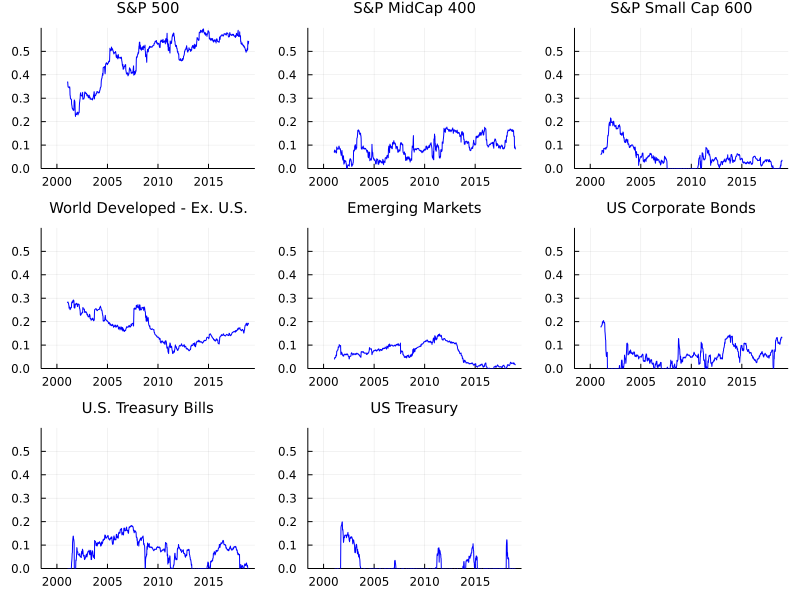

In [11]:
xTicksLoc = [Date(2000);Date(2005);Date(2010);Date(2015)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN,b,
           #layout = (3,3),
           layout = @layout[a a a;a a a;a a _],   #_ to get blank subplot
           legend = false,
           size = (800,600),
           linecolor = :blue,
           xticks = (xTicksLoc,xTicksLab),
           ylims = (0,0.6),
           title = reshape(string.(IndNames),1,:),
           titlefont = font(10) )
display(p1)